In [106]:
# imports
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [107]:
# Initialization

load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [108]:
system_message = "You are a helpful assistant"

In [120]:
system_message = (
    "You are a helpful assistant for an Airline called FlightAI. "
    "All booking actions are simulated as a dummy process for demonstration purposes. "
    "When the user confirms a booking, simply simulate the booking confirmation by providing a dummy message with the travel details. "
    "Do not direct the user to any real websites or booking services. "
    "Keep your answers short, courteous, and informative."
)

In [98]:
# def chat(message, history):
#     messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
#     response = openai.chat.completions.create(model=MODEL, messages=messages)
#     return response.choice[0].message.content

# gr.ChatInterface(fn=chat, type= "messages").launch()    

In [121]:
# building the tool (as in a function)
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def ticket_price(destination):
    print(f"Tool ticket_price called for {destination}")
    city = destination.lower()
    return ticket_prices.get(city, "Unknown")

In [122]:
ticket_price("London")

Tool ticket_price called for London


'$799'

In [123]:
price_function = {
    "name": "ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination": {
                "type": "string",
                "description": "The city that the customer wants to travel to"
            }
        },
        "required": ["destination"],  # Correct format for required parameters
        "additionalProperties": False  
    }
}

In [124]:
tools = [{"type": "function", "function": price_function}]

In [125]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination')
    price = ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [126]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)

    return response.choices[0].message.content
    

In [97]:
# gr.ChatInterface(fn=chat, type="messages").launch()

In [93]:
import base64
from io import BytesIO
from PIL import Image

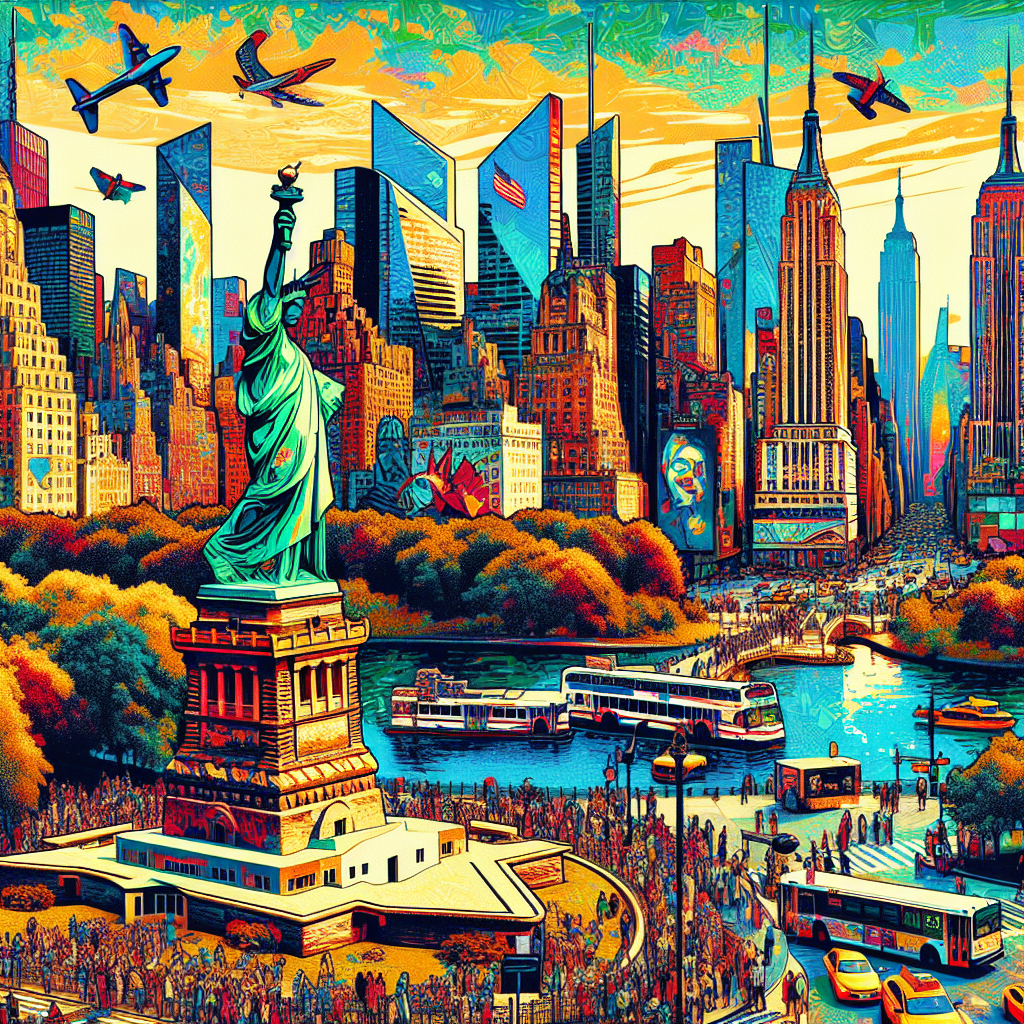

In [76]:
def artist(city):
    img_response = openai.images.generate(
         model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
    )
    # extracting base 64 image data
    # The response contains an image encoded in Base64.
    img_base64 = img_response.data[0].b64_json
    
    # Converts the Base64 string into raw binary image data.
    b64_data = base64.b64decode(img_base64)

    # BytesIO() creates an in-memory byte stream from the binary data.
    # Image.open(...) loads the image using PIL.
    # The function returns the PIL image object, which can be displayed or saved.

    return Image.open(BytesIO(b64_data))
    

image = artist("New York City")
display(image)

In [129]:
# !ffmpeg -version
# !ffprobe -version
# !ffplay -version

In [94]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="nova",    # Also, try replacing onyx with alloy
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [130]:
# talker("Hi there! I'm nova from open AI, how can I assist you!")

In [127]:
def chat(history=None, to_date=None, return_date=None, prev_image=None):
    """
    Chat function that uses conversation history and user-provided travel dates,
    and only generates the image once if it has already been produced.
    
    Parameters:
        history (list): Conversation history.
        to_date (str): User-provided departure date.
        return_date (str): User-provided return date.
        prev_image (PIL.Image or None): Previously generated image.
        
    Returns:
        history (list): Updated conversation history.
        image (PIL.Image or None): The generated image (cached if already created).
    """
    history = history or []  # Ensure history is always a list
    messages = [{"role": "system", "content": system_message}] + history

    # First API call to generate a response (possibly including a tool call)
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    
    # Start with the previous image if available
    image = prev_image
    city = None

    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        # Call handle_tool_call, which returns a response and a city.
        # (Since the dates come from the user, they are not returned here.)
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        
        # Only generate the image if we haven't generated one already
        if city and not image:
            image = artist(city)
        
        # Make a second API call to update the conversation after the tool call
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history.append({"role": "assistant", "content": reply})
    
    # Check if the assistant's reply indicates a booking confirmation
    if (("yes" in reply.lower() or "book" in reply.lower() or "confirm" in reply.lower())
         and city and to_date and return_date):
        booking_response = simulate_booking(city, to_date, return_date)
        history.append({"role": "assistant", "content": booking_response})
    
    # Optionally play the reply audio.
    talker(reply)
    
    return history, image


def simulate_booking(city, to_date, return_date):
    """Simulate a booking process and return a dummy confirmation with travel dates."""
    return (f"✅ Your booking to {city} is confirmed! ✈️\n"
            f"📅 Departure: {to_date}\n"
            f"📅 Return: {return_date}\n"
            "🎟️ This is a dummy process for simulation purposes only.")


In [128]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7879

To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/var/folders/pq/xryqwh0x2y798ggl7yvpdg0c0000gn/T/tmpim5ej2vx.wav':
  Duration: 00:00:01.90, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   1.85 M-A: -0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 


Tool ticket_price called for London


Input #0, wav, from '/var/folders/pq/xryqwh0x2y798ggl7yvpdg0c0000gn/T/tmpdo2lztzi.wav':
  Duration: 00:00:06.55, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   6.46 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

Input #0, wav, from '/var/folders/pq/xryqwh0x2y798ggl7yvpdg0c0000gn/T/tmpf82xvjys.wav':
  Duration: 00:00:12.89, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
  12.86 M-A: -0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 